In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/gdrive


# Zillow Data Cleaning

### Reformat Zillow Data

In [ ]:
def melt_data(df, compress = False, _id_vars=None):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    
    If compress is True will compress data to only the value column.
    """
    if not _id_vars:
      _id_vars = ['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 
                                        'Metro', 'CountyName','RegionType', 'StateName']
                                        
    present_vars = df.columns[df.columns.isin(_id_vars)]
    if not present_vars.empty:

      melted = pd.melt(df,id_vars=present_vars, var_name='time')
    else:
      melted = pd.melt(df, var_name='time')
    
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    resampled = melted.groupby(['RegionName','RegionID','time'])['value'].mean().reset_index()
    resampled['time'] = resampled['time'].apply(lambda x: x.strftime('%Y-%m'))
    return resampled.reset_index()

In [ ]:
home_value = pd.read_csv('/content/gdrive/MyDrive/Phase_4_Project/data/new_zillow_data.csv')
zillow_data = melt_data(home_value)

,index,RegionName,RegionID,time,value
0,0,501,58001,1996-01,NaN
1,1,501,58001,1996-02,NaN
2,2,501,58001,1996-03,NaN
3,3,501,58001,1996-04,NaN
4,4,501,58001,1996-05,NaN
...,...,...,...,...,...
9467568,9467568,99901,100478,2021-03,318919.0
9467569,9467569,99901,100478,2021-04,319969.0
9467570,9467570,99901,100478,2021-05,320923.0
9467571,9467571,99901,100478,2021-06,321739.0


## Import Realtor.com data

In [44]:
rdc_current_inventory = pd.read_csv('/content/gdrive/MyDrive/Phase_4_Project/data/RDC_inventory_currnt_month.csv')
rdc_historical_inventory = pd.read_csv('/content/gdrive/MyDrive/Phase_4_Project/data/RDC_Inventory_Core_Metrics_Zip_History.csv')
rdc_inventory = pd.concat([rdc_current_inventory, rdc_historical_inventory])


rdc_hotness = pd.read_csv('/content/gdrive/MyDrive/Phase_4_Project/data/market_hotness.csv')
# Find the common columns of the inventory and hotness dataframes and merge
common_cols = rdc_hotness.columns[rdc_hotness.columns.isin(rdc_inventory.columns)]
rdc_data = rdc_inventory.merge(rdc_hotness, on=list(common_cols),how='left')[:-1].reset_index()
rdc_data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
 # Target columns for further analysis
 cols =['median_days_on_market', 'median_days_on_market_mm',
       'median_days_on_market_yy', 'new_listing_count', 'new_listing_count_mm',
       'new_listing_count_yy', 'price_increased_count',
       'price_increased_count_mm', 'price_increased_count_yy',
       'price_reduced_count', 'price_reduced_count_mm',
       'price_reduced_count_yy', 'pending_ratio',
       'pending_ratio_mm', 'pending_ratio_yy', 'postal_code', 'time']

# Turn time column into a datetime object
rdc_data['time'] = pd.to_datetime(rdc_data['month_date_yyyymm'].apply(lambda x: str(x)[:4]+'-'+str(x)[4:]), errors='coerce')

# Ensures that the data is on a monthly frequency
rdc_resampled = rdc_data.groupby(['postal_code','time']).mean().reset_index()
rdc_resampled['time'] = rdc_resampled['time'].apply(lambda x: x.strftime('%Y-%m'))

       postal_code  ... median_listing_price_vs_us
0             1001  ...                        NaN
1             1001  ...                        NaN
2             1001  ...                        NaN
3             1001  ...                        NaN
4             1001  ...                        NaN
...            ...  ...                        ...
923931       99801  ...                        NaN
923932       99801  ...                        NaN
923933       99827  ...                        NaN
923934       99901  ...                        NaN
923935       99901  ...                        NaN

[923936 rows x 52 columns]


In [ ]:
# Merge realtor.com and zillow data on postal code and timing columns
zillow_renamed = zillow_data.rename(columns={'RegionName': 'postal_code'})
merged = zillow_renamed.merge(rdc_resampled[cols], on=['postal_code','time']).dropna()
merged

,index,postal_code,RegionID,time,value,median_days_on_market,median_days_on_market_mm,median_days_on_market_yy,new_listing_count,new_listing_count_mm,new_listing_count_yy,price_increased_count,price_increased_count_mm,price_increased_count_yy,price_reduced_count,price_reduced_count_mm,price_reduced_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy
1408,18068,1085,58254,2017-11,237049.0,65.0,-0.150327,-0.103448,28.0,-0.1250,0.1667,0.0,-1.0,-1.0,32.0,-0.2727,0.0000,0.093458,-0.0065,0.0408
3720,46002,1453,58371,2017-08,251413.0,30.0,-0.090909,-0.482759,60.0,0.2500,0.5000,0.0,-1.0,-1.0,32.0,0.6000,0.0000,0.153846,-0.0551,-0.0502
3722,46004,1453,58371,2017-10,254972.0,41.0,-0.046512,-0.068182,60.0,0.1538,0.1538,0.0,-1.0,-1.0,48.0,0.0000,0.0000,0.119266,-0.0457,-0.0130
4071,49071,1475,58384,2017-07,195469.0,66.0,0.389474,-0.014925,8.0,-0.5000,-0.5000,0.0,-1.0,-1.0,8.0,-0.3333,-0.5000,0.194444,-0.0306,-0.0556
4545,52763,1520,58400,2018-03,329895.0,69.0,-0.245902,0.086614,28.0,0.4000,0.7500,0.0,-1.0,-1.0,4.0,-0.5000,-0.5000,0.169811,0.0402,-0.0575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897071,9462345,99654,100334,2020-11,276214.0,66.0,0.269231,-0.043478,28.0,0.0000,-0.3000,0.0,-1.0,-1.0,12.0,0.0000,-0.7692,0.000000,0.0000,0.0000
897074,9462348,99654,100334,2021-02,270558.0,73.0,-0.215054,0.303571,32.0,0.3333,-0.3846,4.0,0.0,0.0,8.0,1.0000,-0.6667,0.000000,0.0000,0.0000
897075,9462349,99654,100334,2021-03,269632.0,43.0,-0.410959,-0.085106,44.0,0.3750,-0.3529,8.0,1.0,1.0,4.0,-0.5000,-0.8333,0.000000,0.0000,0.0000
897076,9462350,99654,100334,2021-04,269720.0,33.0,-0.383178,-0.241379,48.0,0.2000,-0.3684,4.0,-0.5,0.0,8.0,1.0000,-0.7500,0.000000,0.0000,0.0000


In [ ]:
# Filter out for records within the past three years to have relevant data for zip code selection
after_2018 = merged[merged['time'].dt.year >=2019]

# Ensures that each record has at least 25 months worth of data
filtered_df = merged.groupby(['postal_code']).filter(lambda x:len(x) >= 25).set_index(['time','postal_code'])
cols = 'value	median_days_on_market	median_days_on_market_mm	median_days_on_market_yy	new_listing_count	new_listing_count_mm	new_listing_count_yy	price_increased_count	price_increased_count_mm	price_increased_count_yy	price_reduced_count	price_reduced_count_mm	price_reduced_count_yy	pending_ratio	pending_ratio_mm	pending_ratio_yy'.split()

# Scales the data for accurate weighting and create feature averages for each zip code
_df_scaled = pd.DataFrame(StandardScaler().fit_transform(filtered_df[cols]), index = filtered_df.index, columns=cols).reset_index()
df_scaled = _df_scaled.groupby('postal_code').mean()

## Zip code Selection 

In [3]:
def get_n_highest_scores(df, weights, n):
  scores = pd.Series()
  for col, weight in weights.items():
    weighted_col = df[col] * weight
    if scores.empty:
      scores = weighted_col
    else:
      scores += weighted_col 
  n_best = scores.sort_values(ascending=False)[:n]
  return n_best

In [ ]:
# Selects the top five zipcodes with the highest scores
weights = {'value':0.4, 'median_days_on_market_mm':-0.2,'price_increased_count_mm':2,'pending_ratio_mm':.2}
get_n_highest_scores(df_scaled, weights, 5).index


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Int64Index([84045, 98642, 28546, 80016, 80516], dtype='int64', name='postal_code')

## Plotting

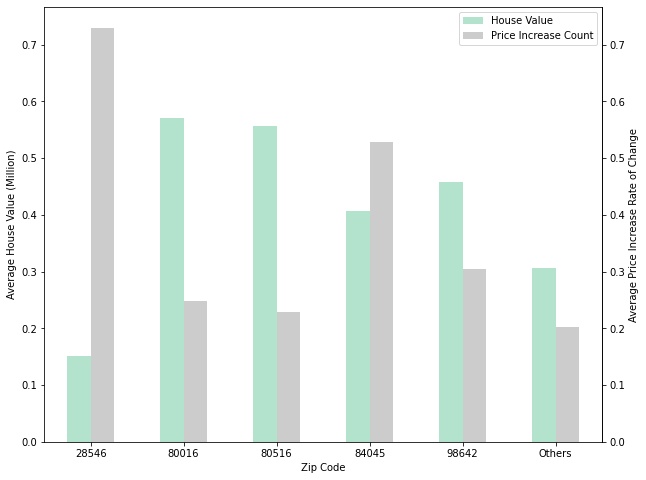

In [79]:
def plot_em(df, cols, zipcodes):
  # Select target zipcodes from df and average columns
  target_df = df.loc[df.postal_code.isin(zipcodes),cols+['postal_code']].set_index('postal_code')
  
  # Average the other zip codes and add to plotting dataframe
  others = df.loc[~df.postal_code.isin(zipcodes), cols].mean()
  target_df.loc["Others"] = others.values

  # Rename and reformat axis for aesthetics
  target_df['value'] = target_df['value']/1000000
  target_df = target_df.rename(columns={'value': 'House Value', 'price_increased_count_mm':'Price Increase Count'})
  ax = target_df.plot.bar(cmap='Pastel2',figsize=(10,8))
  ax.set_ylabel('Average House Value (Million)')
  
  # Initalize second y axis 
  sec_yaxis = ax.secondary_yaxis(location='right')
  sec_yaxis.set_ylabel("Average Price Increase Rate of Change")

  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
  ax.set_xlabel('Zip Code')

plot_em(new.reset_index(), ['value', 'price_increased_count_mm'],[84045, 98642, 28546, 80016, 80516]) 

4/5 selected zipcodes contain houses with higher values than the other zipcodes combined. Zip code 28546 has homes with lower values, but a very high price increase rate of change. This indicates an 'up and coming' zip code, where the homes have consistently garnered value throughout time.





                                 0  median_days_on_market_mm  pending_ratio_mm
28546                          NaN                  0.011568          0.157283
80016                          NaN                  0.040345          0.066588
80516                          NaN                  0.059299          0.099205
84045                          NaN                  0.082466          0.295388
98642                          NaN                  0.027138          0.129953
Others                         NaN                  0.011317          0.056378
pending_ratio_mm          0.056378                       NaN               NaN
median_days_on_market_mm  0.011317                       NaN               NaN


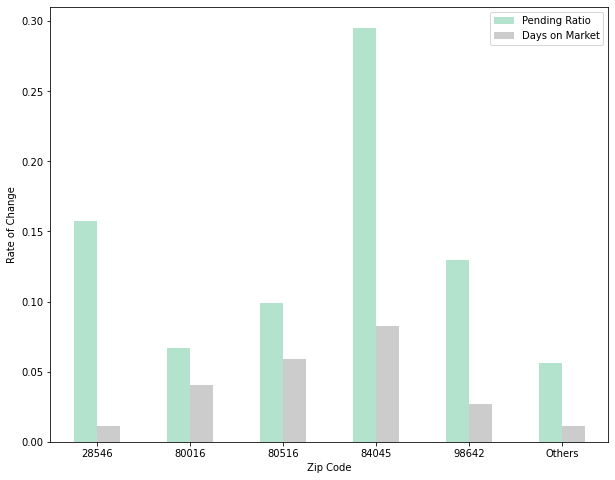

In [74]:
def plot_em(df, cols, zipcodes):
  # Select target zipcodes from df and average columns
  target_df = df.loc[df.postal_code.isin(zipcodes),cols+['postal_code']].set_index('postal_code')
  
  # Average the other zip codes and add to plotting dataframe
  others_avg = df.loc[~df.postal_code.isin(zipcodes),cols].mean()
  target_df.loc['Others',:] = others_avg.values
  
  # Rename and reformat axis for aesthetics
  target_df = target_df.rename(columns={'pending_ratio_mm':'Pending Ratio', 'median_days_on_market_mm':'Days on Market'})
  ax = target_df.plot.bar(cmap='Pastel2',figsize=(10,8))
  ax.set_ylabel("Rate of Change")
  
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
  ax.set_xlabel('Zip Code')

  
plot_em(new.reset_index(), ['pending_ratio_mm','median_days_on_market_mm'],[84045, 98642, 28546, 80016, 80516]) 

The average days a property is on the market is not a sufficient indicator of consumer demand, because pending properties, or properties that have accepted offers, are still considered 'on the market'. 

To judge consumer readiness, we selected zipcodes that outpreformed the other zipcodes for increased the number of pending houses while having comparitavely lower days on market increases.

## MPL Regression

In [60]:
from sklearn.neural_network import MLPRegressor
import math
import datetime as dt
import pandas as pd
import numpy as np


def segment_data(X,y):
    #splits data to train and test
    index_range, split_index = np.arange(len(X)), math.ceil(len(X)*.8)
    train_index, test_index = index_range[:split_index], index_range[split_index:]
    
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    return (X_train, y_train), (X_test, y_test)

def calc_rmse(y_hat,y_true):
  # Calculates rmse
  sum_squared_diff = np.sum([(y_pred-y)**2 for y_pred,y_true in zip(y_hat,y_true)])
  return sum_squared_diff**0.5

def mpl_regressor(X,y, model_kwargs={}):
    # A cool regressor function
    (X_train, y_train), (X_test,y_test) = segment_data(X,y)
    regr = MLPRegressor(**model_kwargs).fit(X_train, y_train)
    
    _X_test = X_test[X_test['postal_code'] == 84045]
    _y_test = y_test[_X_test.index]
    
    predictions = regr.predict(_X_test.values)
    rmse = calc_rmse(predictions,_y_test)
    return rmse



# Gets the data ready for 
_df = _df_scaled.reset_index().copy()
target_df = _df.sort_values(by='time').drop(columns=['time', 'index']) 
X, y = target_df.drop(columns='value'), target_df['value']

mpl_regressor(X,y, {'learning_rate':'adaptive'
                      ,'max_iter': 300
                      ,'solver':'adam'
                      ,'shuffle':False})

684.009368957799